#### LadderNet training

In [1]:
# Standard
import os
import sys
import datetime
import numpy as np
import matplotlib.pyplot as plt

# Utils
import h5py

# Deep Learning
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

# User defined
sys.path.insert(0, "../")
from architectures.laddernet import LadderNet
from architectures.unet import UNet
from metrics.multiclass_dice import multiclass_dice

2022-09-20 23:53:49.935799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-20 23:53:50.055076: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-20 23:53:50.450728: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/lars/miniconda3/envs/ai4mi/lib/
2022-09-20 23:53:50.450793: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plug

In [2]:
f = h5py.File("../data/image_dataset.hdf5", "r")
# print(type(f["train 2ch frames"][:,:,:,:]))

In [3]:
frames2ch = f["train 2ch frames"][:,:,:,:]
masks2ch = f["train 2ch masks"][:,:,:,:]

In [4]:
print(frames2ch.shape)

(900, 384, 384, 1)


In [5]:
train_frames, test_frames, train_masks, test_masks = train_test_split(frames2ch, masks2ch)

In [6]:
model_laddernet = LadderNet(input_size=(384, 384, 1), num_classes=4, filters=20)
model_unet = UNet(input_size=(384, 384, 1), depth=5, num_classes=4, filters=10, batch_norm=True)

2022-09-20 23:53:51.978479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-20 23:53:51.993471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-20 23:53:51.993821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-20 23:53:51.994377: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [7]:
earlystop = EarlyStopping(monitor='val_multiclass_dice', min_delta=0, patience=5,
                          verbose=1, mode="max", restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_multiclass_dice', factor=0.2, patience=2,
                              verbose=1, mode="max", min_lr=1e-5)

In [8]:
model_laddernet.compile(optimizer=Adam(lr=1e-3), loss="sparse_categorical_crossentropy", metrics=[multiclass_dice, "accuracy"])

/home/lars/miniconda3/envs/ai4mi/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


#### Now we are ready to train our DNN model!

In [9]:
model_laddernet.fit(x=train_frames,
                    y=train_masks,
                    validation_data=[test_frames, test_masks],
                    batch_size=5,
                    epochs=150,
                    callbacks=[earlystop, reduce_lr])

2022-09-20 23:53:56.581306: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 398131200 exceeds 10% of free system memory.
2022-09-20 23:53:56.755085: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 398131200 exceeds 10% of free system memory.
2022-09-20 23:53:56.834317: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 398131200 exceeds 10% of free system memory.


Epoch 1/150


2022-09-20 23:54:00.246892: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-09-20 23:54:01.640831: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-20 23:54:01.701079: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-20 23:54:01.701126: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-09-20 23:54:01.748184: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-20 23:54:01.748282: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


135/135 [==============================] - 43s 261ms/step - loss: 0.6692 - multiclass_dice: 0.5067 - accuracy: 0.7891 - val_loss: 141.6783 - val_multiclass_dice: 0.2429 - val_accuracy: 0.2994 - lr: 0.0010
Epoch 2/150
135/135 [==============================] - 28s 211ms/step - loss: 0.3280 - multiclass_dice: 0.6779 - accuracy: 0.8867 - val_loss: 4.8083 - val_multiclass_dice: 0.3570 - val_accuracy: 0.5761 - lr: 0.0010
Epoch 3/150
135/135 [==============================] - 29s 211ms/step - loss: 0.2880 - multiclass_dice: 0.6983 - accuracy: 0.8935 - val_loss: 0.9454 - val_multiclass_dice: 0.6194 - val_accuracy: 0.8153 - lr: 0.0010
Epoch 4/150
135/135 [==============================] - 28s 211ms/step - loss: 0.2616 - multiclass_dice: 0.7225 - accuracy: 0.9012 - val_loss: 0.7124 - val_multiclass_dice: 0.5884 - val_accuracy: 0.8288 - lr: 0.0010
Epoch 5/150
135/135 [==============================] - ETA: 0s - loss: 0.2393 - multiclass_dice: 0.7417 - accuracy: 0.9076
Epoch 5: ReduceLROnPlateau 

In [10]:
model_unet.compile(optimizer=Adam(lr=1e-3), loss="sparse_categorical_crossentropy", metrics=[multiclass_dice, "accuracy"])

In [11]:
model_unet.fit(x=train_frames,
                    y=train_masks,
                    validation_data=[test_frames, test_masks],
                    batch_size=5,
                    epochs=150,
                    callbacks=[earlystop, reduce_lr])

Epoch 1/150


2022-09-21 00:10:23.260275: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 398131200 exceeds 10% of free system memory.
2022-09-21 00:10:23.860328: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 398131200 exceeds 10% of free system memory.


135/135 [==============================] - 11s 60ms/step - loss: 0.7957 - multiclass_dice: 0.6733 - accuracy: 0.8378 - val_loss: 6.9003 - val_multiclass_dice: 0.2590 - val_accuracy: 0.3079 - lr: 0.0010
Epoch 2/150
135/135 [==============================] - 7s 52ms/step - loss: 0.5723 - multiclass_dice: 0.7678 - accuracy: 0.9114 - val_loss: 4.3870 - val_multiclass_dice: 0.2920 - val_accuracy: 0.3101 - lr: 0.0010
Epoch 3/150
135/135 [==============================] - 7s 51ms/step - loss: 0.4742 - multiclass_dice: 0.7845 - accuracy: 0.9192 - val_loss: 1.4133 - val_multiclass_dice: 0.4033 - val_accuracy: 0.6082 - lr: 0.0010
Epoch 4/150
135/135 [==============================] - 7s 52ms/step - loss: 0.4044 - multiclass_dice: 0.7910 - accuracy: 0.9231 - val_loss: 0.5391 - val_multiclass_dice: 0.7340 - val_accuracy: 0.8922 - lr: 0.0010
Epoch 5/150
135/135 [==============================] - 7s 52ms/step - loss: 0.3521 - multiclass_dice: 0.7995 - accuracy: 0.9272 - val_loss: 0.9819 - val_multic

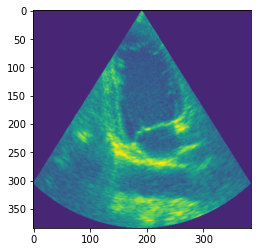

In [12]:
plt.imshow(train_frames[0,:,:,0])

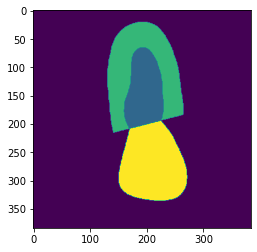

In [13]:
plt.imshow(train_masks[0,:,:,0])

In [14]:
prediction = model_laddernet.predict(train_frames[:1,:,:,:])

1/1 [==============================] - 1s 669ms/step


In [15]:
prediction_u = model_unet.predict(train_frames[:1,:,:,:])

1/1 [==============================] - 1s 536ms/step


In [16]:
prediction = prediction.reshape([384, 384, 4])
prediction_u = prediction_u.reshape([384, 384, 4])
prediction.shape

(384, 384, 4)

In [17]:
import tensorflow as tf

In [18]:
y = tf.convert_to_tensor(prediction)
y_u = tf.convert_to_tensor(prediction_u)

In [19]:
z = tf.math.argmax(prediction, axis = 2)
z_u = tf.math.argmax(prediction_u, axis = 2)

#### Prediction visualization

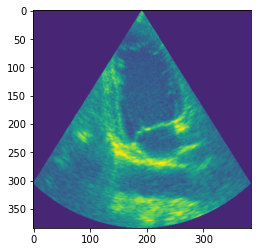

In [20]:
plt.imshow(train_frames[0,:,:,0])

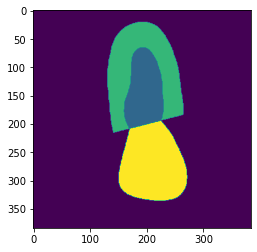

In [21]:
plt.imshow(train_masks[0,:,:,0])

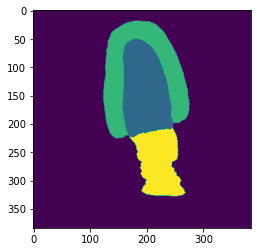

In [22]:
plt.imshow(z[:,:])
plt.show()

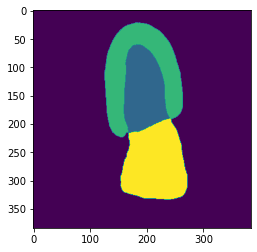

In [23]:
plt.imshow(z_u[:,:])
plt.show()

#### Model weights storage

In [24]:
model_laddernet.save_weights("../models/ladder088_2ch_4real.h5")

In [26]:
model_unet.save_weights("../models/unet_2ch.h5")